## Analyze Logs of Evaluation Runs 

- Copy the AWS RoboMaker evaluation simulation identification number. 
- AWS SageMaker training job saves checkpoint and frozen graphs into an S3 model bucket. Copy the bucket and prefix from your training job.

In [ ]:
s3_bucket = 'FILL_HERE'
s3_prefix = 'FILL_HERE'

## Imports 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import os
os.getcwd()

'/home/ec2-user/SageMaker/challenge_submit'

## AWS Robomaker

In [3]:
from log_analysis import *
import cw_utils

In [4]:
# Make sure your boto version is >= '1.9.133'
cw_utils.boto3.__version__

'1.10.1'

### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

Make sure your notebook has the IAM role to filter the Amazon Cloudwatch logs to download only the simulation specific logs needed for analysis. For information on using identity-based Policies (IAM Policies) for Amazon CloudWatch logs:
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/iam-identity-based-access-control-cwl.html

In [5]:
if os.path.exists('logs/'):
    !rm -r logs
!mkdir logs


stream_name_list = ['sim-4qwwj480fs6s'] ## you can use the list to look at multiple eval logs
for idx, stream_name in enumerate(stream_name_list):
    fname = 'logs/deepracer-%s.log' %stream_name
    cw_utils.download_log(fname, stream_prefix=stream_name)
!tail -n 10 $fname

Writing to ...  logs/deepracer-sim-4qwwj480fs6s.log
SIM_TRACE_LOG:1125,42,6.8015,2.6702,-0.6135,-0.26,3.50,2,0.5000,False,True,15.8811,23,17.67,1568562200.085531
SIM_TRACE_LOG:1125,43,6.8508,2.6224,-0.6751,-0.26,3.50,2,1.0000,False,True,16.2683,23,17.67,1568562200.1542077
SIM_TRACE_LOG:1125,44,6.8959,2.5742,-0.7292,0.26,3.50,6,1.0000,False,True,16.6376,23,17.67,1568562200.2180154
SIM_TRACE_LOG:1125,45,6.9442,2.5243,-0.7577,0.26,3.50,6,1.0000,False,True,17.0274,22,17.67,1568562200.2853398
SIM_TRACE_LOG:1125,46,6.9943,2.4700,-0.7860,-0.26,3.50,2,1.0000,False,True,17.4412,22,17.67,1568562200.3556523
SIM_TRACE_LOG:1125,47,7.0364,2.4220,-0.8093,0.26,3.50,6,1.0000,False,True,17.7721,22,17.67,1568562200.4178455
SIM_TRACE_LOG:1125,48,7.0837,2.3685,-0.8248,-0.26,3.50,2,1.0000,False,True,18.1757,21,17.67,1568562200.4868064
SIM_TRACE_LOG:1125,49,7.1277,2.3145,-0.8500,-0.26,3.50,2,1.0000,False,True,18.5465,21,17.67,1568562200.5533633
SIM_TRACE_LOG:1125,50,7.1690,2.2596,-0.8791,-0.26,3.50,2,1.0000,

In [ ]:
# parse the number of checkpoint from the logs
checkpoints, data = load_checkpoints(fname)
    
print(len(checkpoints))
print(len(data))
print(checkpoints[-1])

## Parse the logs for analysis

In [20]:
color = ['r.', 'b.', 'g.', 'c.']
mean_max_progress = list()
std_max_progress = list()
checkpoint_max_progress = list()
path_list = list()

for idx, stream_name in enumerate(stream_name_list):
    fname = 'logs/deepracer-%s.log' %stream_name
    checkpoints, data_checkpoints = load_checkpoints(fname)
    
    full_lap_idx_per_checkpoint = []
    
    for idxchk in range(0, len(checkpoints) - 1):
        data = data_checkpoints[idxchk]
        df = convert_to_pandas(data, None)
        
        REWARD_THRESHOLD = 1000

        # reward graph per episode
        min_episodes = np.min(df['episode'])
        max_episodes = np.max(df['episode'])
        #print('Number of episodes = ', max_episodes)

        total_reward_per_episode = list()
        max_progress_per_episode = list()
        steps_progress_per_episode = list()
        path = list()

        for epi in range(min_episodes, max_episodes):
            df_slice = df[df['episode'] == epi]
            total_reward_per_episode.append(np.sum(df_slice['reward']))
            max_progress_per_episode.append(np.max(df_slice['progress']))
            if len(df_slice) > 0:
                steps_progress_per_episode.append(len(df_slice))
            else:
                steps_progress_per_episode.append(float('nan'))
            if np.max(df_slice['progress']) >= 99:    
                path.append((df_slice['x'], df_slice['y']))   

        checkpoint_max_progress.append(idxchk)
        mean_max_progress.append(np.mean(max_progress_per_episode))    
        std_max_progress.append(np.std(max_progress_per_episode))
        
        #
        full_lap_idx = np.where(np.array(max_progress_per_episode) >= 100)[0]
        full_lap_idx_per_checkpoint.append(full_lap_idx)
        
        if np.mean(max_progress_per_episode) >= 95:
            path_list.append({'model':idxchk, 'path': path, 'full_laps': full_lap_idx.shape[0]})
        
        print ("Laps completed for Checkpoint %s = %s (out of 15)" %(idxchk,full_lap_idx.shape[0]))

Laps completed for Checkpoint 0 = 0 (out of 15)
Laps completed for Checkpoint 1 = 0 (out of 15)
Laps completed for Checkpoint 2 = 0 (out of 15)
Laps completed for Checkpoint 3 = 0 (out of 15)
Laps completed for Checkpoint 4 = 0 (out of 15)
Laps completed for Checkpoint 5 = 0 (out of 15)
Laps completed for Checkpoint 6 = 0 (out of 15)
Laps completed for Checkpoint 7 = 0 (out of 15)
Laps completed for Checkpoint 8 = 0 (out of 15)
Laps completed for Checkpoint 9 = 0 (out of 15)
Laps completed for Checkpoint 10 = 0 (out of 15)
Laps completed for Checkpoint 11 = 0 (out of 15)
Laps completed for Checkpoint 12 = 0 (out of 15)
Laps completed for Checkpoint 13 = 0 (out of 15)
Laps completed for Checkpoint 14 = 0 (out of 15)
Laps completed for Checkpoint 15 = 0 (out of 15)
Laps completed for Checkpoint 16 = 0 (out of 15)
Laps completed for Checkpoint 17 = 0 (out of 15)
Laps completed for Checkpoint 18 = 0 (out of 15)
Laps completed for Checkpoint 19 = 0 (out of 15)
Laps completed for Checkpoint 

In [21]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

track_name = 'reinvent_base'
waypoints = get_track_waypoints(track_name) ### re:invent track
waypoints.shape

# convert to cm
l_inner_border = 100*waypoints[:,2:4]
l_outer_border = 100*waypoints[:,4:6]

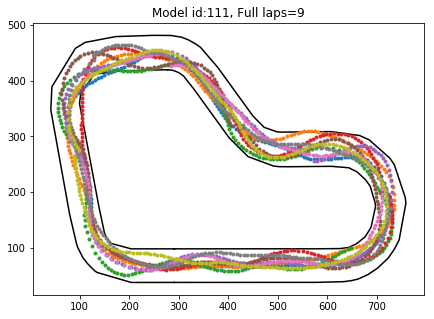

In [22]:
model_list_candidates = [111]
for dval in path_list:
    if dval['model'] in model_list_candidates:
        fig = plt.figure(figsize=(7, 5))
        ax1 = fig.add_subplot(111)
        ax1.plot(l_inner_border[:,0], l_inner_border[:,1], 'k-')
        ax1.plot(l_outer_border[:,0], l_outer_border[:,1], 'k-')
        for val in dval['path']:
            ax1.plot(val[0], val[1], '.')
            ax1.set_title('Model id:%d, Full laps=%d' % (dval['model'], dval['full_laps']))

### Plot mean and std of the progress per checkpoint

In [ ]:
fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(checkpoint_max_progress, mean_max_progress, '.')
ax1.set_xlabel('Checkpoint')
ax1.set_ylabel('Percent')
ax1.set_title('Mean max progress')
ax1.set_ylim((50, 105))

ax2.plot(checkpoint_max_progress, std_max_progress, '.')
ax2.set_xlabel('Checkpoint')
ax1.set_ylabel('Percent')
ax2.set_title('Std max progress')

### NOTE: Make sure your max-progress is 100% for at least a single checkpoint, else the model submission won't be accepted.  100% progress indicates that you have completed a lap.

Select the checkpoint ID of the model you wish to download

#### list all the model files

In [ ]:
!aws s3 ls s3://{s3_bucket}/{s3_prefix}/model/

## To submit ...

Your submission should contain the neural network model, action space definition, evaluation logs, and output head name for the neural network to test your model on the AWS DeepRacer robocar.

Refer 2_submit-NeurIPS.ipynb notebook to submit your model
